# Notes

# Imports

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial import distance
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL
from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
from post_processing import contiguous_regions
from windowed_prob_utils import return_overlapping_windows_for_timeframes, compute_windowed_distribution_array_from_1D_tseries
from windowed_prob_utils import get_fightbout_rectangle_info


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the tracking data

In [3]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

# compute the $\Delta P_{Z}$, $O_{Z}$ vars

In [38]:
# ---- generate the state variables for all exps ---- #


t0 = time.perf_counter()


exp_Ozs = []
exp_signed_deltaZs = []

for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    Oz = compute_coordinate_origin_z(smooth_traj, winIdx, losIdx)
    deltaZ = compute_signed_pec_z_difference(smooth_traj, winIdx, losIdx)
    
    exp_Ozs.append(Oz)
    exp_signed_deltaZs.append(deltaZ)

    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538
FishTank20200129_140656
FishTank20200130_153857
FishTank20200130_181614
FishTank20200207_161445
FishTank20200213_154940
FishTank20200214_153519
FishTank20200217_160052
FishTank20200218_153008
FishTank20200316_163320
FishTank20200327_154737
FishTank20200330_161100
FishTank20200331_162136
FishTank20200520_152810
FishTank20200521_154541
FishTank20200525_161602
FishTank20200526_160100
FishTank20200527_152401
FishTank20200824_151740
FishTank20200828_155504
FishTank20200902_160124
FishTank20200903_160946

finished: 3.453233681153506 s


# prepare the arrays for indexing within fights and outside fights

For this figure, we will use without the size threshold on bout duration

In [39]:
figure_bout_info = np.copy(fight_bout_info_noDurThresh)

# the set of expIdxs that have contributions to figure_bout_info
chosen_expIdxs = np.unique(figure_bout_info[:,0])

numBouts = figure_bout_info.shape[0]

figure_bout_info.shape

(33, 4)

In [40]:
# ---- prepare the nonfight regions ----#
# based on 'figure_bout_info'

chosen_expIdx_nonFight_regions = []

for expIdx in chosen_expIdxs:
    expName = expNames[expIdx]
    
    # find the bouts for this exp
    fight_epoch_array_rows = np.where(figure_bout_info[:,0] == expIdx)[0]
    
    # turn into list format over bouts, data is (startFrame,stopFrame)
    exp_fight_bout_lims_list = []
    for rowIdx in fight_epoch_array_rows:
        fight_bout_lims = figure_bout_info[rowIdx,1:3]
        exp_fight_bout_lims_list.append(fight_bout_lims)
        
    # now, prepare a binary timeseries of fight/non-fight membership for all frames,
    # recording all fights as truth
    expnfs = expNumFrames[expIdx]
    exp_fightFrame_bin_arr = np.zeros((expnfs,), dtype=bool)
    for bIdx in range(len(exp_fight_bout_lims_list)):
        exp_fightFrame_bin_arr[ exp_fight_bout_lims_list[bIdx][0]:exp_fight_bout_lims_list[bIdx][1]] = True
        
    # now find contiguous regions of the inverse of this array, 
    # giving us frame ranges where the fish are not fighting
    exp_non_fight_regions = contiguous_regions(~exp_fightFrame_bin_arr)
    
    # record
    chosen_expIdx_nonFight_regions.append([expIdx, exp_non_fight_regions])
    
    
# make into array along fightbouts with expIdxs
figure_nonBout_info = []
for vals in chosen_expIdx_nonFight_regions:
    expIdx = vals[0]
    boutInfo = vals[1]
    expIdx_with_boutInfo_arr = np.full((boutInfo.shape[0],3), fill_value=expIdx)
    expIdx_with_boutInfo_arr[:,1:] = boutInfo
    figure_nonBout_info.append(expIdx_with_boutInfo_arr)
figure_nonBout_info = np.concatenate(figure_nonBout_info, axis=0)

numNoNBouts = figure_nonBout_info.shape[0]

In [41]:
figure_nonBout_info

array([[      0,       0,  385500],
       [      0,  427400,  583500],
       [      0,  610400,  643500],
       [      0,  805400,  971756],
       [      1,       0,  274500],
       [      1,  301400,  385700],
       [      1,  409400,  493700],
       [      1,  655400,  700700],
       [      1,  718600,  769848],
       [      2,       0,   31500],
       [      2,  175400,  301300],
       [      2,  319600,  501943],
       [      3,       0,  331300],
       [      3,  436400,  517000],
       [      5,       0,  448500],
       [      5,  559400,  730119],
       [      6,       0,  217700],
       [      6,  250400,  495610],
       [      7,       0,   91500],
       [      7,  127400,  505500],
       [      7,  553400,  601226],
       [      8,       0,  181500],
       [      8,  256200,  274700],
       [      8,  334400,  352500],
       [      8,  370400,  537880],
       [     10,       0,   19700],
       [     10,   79400,  561010],
       [     11,       0,  2

# gathering vars in fights and out

In [42]:
# ----- fighting ---- #


master_fight_Ozs = []
master_fight_signed_deltaZs = []

for boutIdx in range(numBouts):
    
    expIdx, f0, fE, bout_duration = figure_bout_info[boutIdx]
    
    bout_Oz = np.copy( exp_Ozs[expIdx][f0:fE] ) 
    bout_signed_deltaZ = np.copy( exp_signed_deltaZs[expIdx][f0:fE] )
    
    master_fight_Ozs.append(bout_Oz)
    master_fight_signed_deltaZs.append(bout_signed_deltaZ)
    
# concatenate the results
master_fight_Ozs = np.concatenate(master_fight_Ozs)
master_fight_signed_deltaZs = np.concatenate(master_fight_signed_deltaZs)

    


In [43]:
# ---- non-fighting ---- #


master_nonfight_Ozs = []
master_nonfight_signed_deltaZs = []

for boutIdx in range(numNoNBouts):
    
    expIdx, f0, fE = figure_nonBout_info[boutIdx]
    
    bout_Oz = np.copy( exp_Ozs[expIdx][f0:fE] ) 
    bout_signed_deltaZ = np.copy( exp_signed_deltaZs[expIdx][f0:fE] )
    
    master_nonfight_Ozs.append(bout_Oz)
    master_nonfight_signed_deltaZs.append(bout_signed_deltaZ)
    

# concatenate the results
master_nonfight_Ozs = np.concatenate(master_nonfight_Ozs)
master_nonfight_signed_deltaZs = np.concatenate(master_nonfight_signed_deltaZs)



In [27]:

# master_fight_Ozs 
# master_fight_signed_deltaZs 

# master_nonfight_Ozs 
# master_nonfight_signed_deltaZs


# Panel A

## rough version

Text(0.5, 0, 'delta Z')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
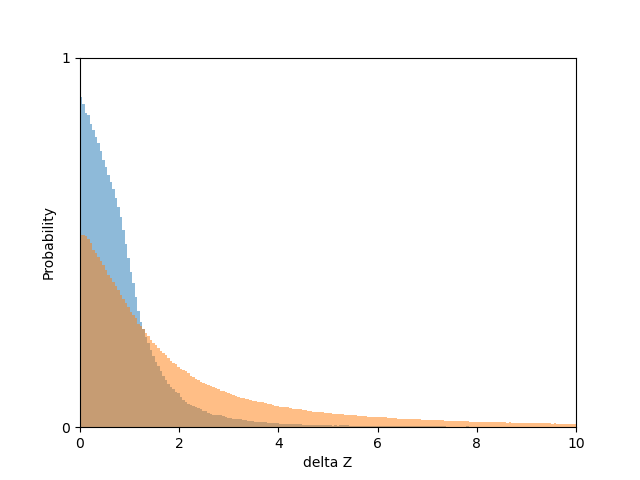

In [49]:
fig, axs = plt.subplots()
ax = axs


delta_z_bins = np.linspace(0, 10,200)

bout_out = ax.hist(np.abs(master_fight_signed_deltaZs), bins=delta_z_bins, label='fight bouts', alpha=0.5, density=True);
nonbout_out =ax.hist(np.abs(master_nonfight_signed_deltaZs), bins=delta_z_bins, label='non fights', alpha=0.5, density=True);

ax.set_xlim(0,10)
ax.set_ylim(0,1)

ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0, 1])

ax.set_ylabel('Probability')
ax.set_xlabel('delta Z')

# ---------- #


In [46]:
np.nanmean(np.abs(master_fight_signed_deltaZs))

0.9621015543525373

In [47]:
np.nanmean(np.abs(master_nonfight_signed_deltaZs))

3.0991164806156988

In [69]:
# find the max vals

In [48]:
np.sum(bout_out[0])*(delta_z_bins[1]-delta_z_bins[0])

1.0

In [30]:
# -------------------------------------$

## paper version

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
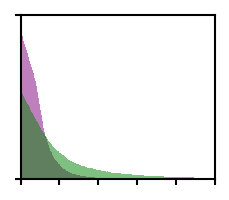

In [52]:
fig, axs = plt.subplots(figsize=(2.3,2))
ax = axs


delta_z_bins = np.linspace(0, 10,200)

bout_out = ax.hist(np.abs(master_fight_signed_deltaZs), bins=delta_z_bins, label='fight bouts', alpha=0.5, density=True, color='purple');
nonbout_out =ax.hist(np.abs(master_nonfight_signed_deltaZs), bins=delta_z_bins, label='non fights', alpha=0.5, density=True, color='green');

ax.set_xlim(0,10)
ax.set_ylim(0,1)

ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0, 1])

ax.set_ylabel('Probability')
ax.set_xlabel('delta Z')

# ---------- #

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)

fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/SI_fig_deltaZ_A.png', dpi=300, transparent=True)

In [51]:
# find the max value for y axis
yupperlim = 1
yupperprob = yupperlim*(delta_z_bins[1]-delta_z_bins[0])
yupperprob 

0.05025125628140704

# Panel B

## calculation

In this figure, we want to only use fights longer than 7 mins (like figure7), <br>
so we use the appropriate fight boundaries

In [53]:
figure_bout_info = np.copy(fight_bout_info)

numBouts = figure_bout_info.shape[0]
numBouts

18

In [54]:
figure_bout_info

array([[     0, 643500, 805400, 161900],
       [     1, 493700, 655400, 161700],
       [     2,  31500, 175400, 143900],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15,  13500, 184400, 170900],
       [    18, 388700, 556400, 167700],
       [    19, 526700, 571200,  44500],
       [    20,  40900, 169600, 128700]])

In [55]:
frameGap = 30000 # the number of frames either side of the start and stops

In [56]:
# ----------------- Get the 4 frame ranges for each bout ------------------------#
#
# We will get the start&stop frame for each bout for each of these 4 regions
#
#
#       <---- nofight---><----fight----><------nofight---->
#      ------------|---()---|------|---()---|----------------
#                  <1>   <2>       <3>   <4>
#
# <1> = pre fight start
# <2> = post fight start
# <3> = pre fight end
# <4> = post fight end


pre_fight_begins_start_stops = np.zeros((numBouts, 2), dtype=int)
post_fight_begins_start_stops = np.zeros((numBouts, 2), dtype=int)

pre_fight_ends_start_stops = np.zeros((numBouts, 2), dtype=int)
post_fight_ends_start_stops = np.zeros((numBouts, 2), dtype=int)


for boutIdx in range(numBouts):
    
    # parse the info for this bout
    expIdx, fight_begin, fight_end, _ = figure_bout_info[boutIdx]
    #print(expIdx, fight_start, fight_stop)
    
    # record the 4 time-windows required from this bout
    
    pre_fight_begins_start_stops[boutIdx,0] = fight_begin - frameGap
    pre_fight_begins_start_stops[boutIdx,1] = fight_begin
    
    post_fight_begins_start_stops[boutIdx,0] = fight_begin
    post_fight_begins_start_stops[boutIdx,1] = fight_begin + frameGap
    
    pre_fight_ends_start_stops[boutIdx,0] = fight_end - frameGap
    pre_fight_ends_start_stops[boutIdx,1] = fight_end
    
    post_fight_ends_start_stops[boutIdx,0] = fight_end
    post_fight_ends_start_stops[boutIdx,1] = fight_end + frameGap
    

In [60]:
# ----------------- Use these 4 frame ranges to grab the data  ------------------------#

#1
pre_fight_begins_Oz_list = []

#2
post_fight_begins_Oz_list = []

#3
pre_fight_ends_Oz_list = []

#4
post_fight_ends_Oz_list = []


excluded_pre_begin_boutIdxs = []

for boutIdx in range(numBouts):
    
    # get the state vars for the experiment this bout comes from
    expIdx, fight_begin, fight_end, _ = figure_bout_info[boutIdx]
    exp_Oz = exp_Ozs[expIdx]

    # get the 4 frame ranges for this bout
    pre_begin_f0, pre_begin_fE = pre_fight_begins_start_stops[boutIdx]
    post_begin_f0, post_begin_fE = post_fight_begins_start_stops[boutIdx]
    pre_end_f0, pre_end_fE = pre_fight_ends_start_stops[boutIdx]
    post_end_f0, post_end_fE = post_fight_ends_start_stops[boutIdx]
    
    # deal with the starts first, where we might hit against the start of the experiment.
    # In this case we cant get enough frames, so we will exclude these experiments
    if pre_begin_f0 <= 0:
        excluded_pre_begin_boutIdxs.append(boutIdx)
        
        # 1 edge case to skip
        #pre_fight_begins_Oz_list

        # 3 regular cases
        post_fight_begins_Oz_list.append( np.copy(exp_Oz[post_begin_f0:post_begin_fE]) )
        pre_fight_ends_Oz_list.append( np.copy(exp_Oz[pre_end_f0:pre_end_fE]) )
        post_fight_ends_Oz_list.append( np.copy(exp_Oz[post_end_f0:post_end_fE]) )

    else:
        # 4 regular cases
        pre_fight_begins_Oz_list.append( np.copy(exp_Oz[pre_begin_f0:pre_begin_fE]) )
        post_fight_begins_Oz_list.append( np.copy(exp_Oz[post_begin_f0:post_begin_fE]) )
        pre_fight_ends_Oz_list.append( np.copy(exp_Oz[pre_end_f0:pre_end_fE]) )
        post_fight_ends_Oz_list.append( np.copy(exp_Oz[post_end_f0:post_end_fE]) )


        
# convert to arrays

#1
pre_fight_begins_Oz_arr = np.stack(pre_fight_begins_Oz_list, axis=0)

#2
post_fight_begins_Oz_arr = np.stack(post_fight_begins_Oz_list, axis=0)

#3
pre_fight_ends_Oz_arr = np.stack(pre_fight_ends_Oz_list, axis=0)

#4
post_fight_ends_Oz_arr= np.stack(post_fight_ends_Oz_list, axis=0)

epoch_Oz_arrs = [pre_fight_begins_Oz_arr, post_fight_begins_Oz_arr,
                 pre_fight_ends_Oz_arr, post_fight_ends_Oz_arr]


print(pre_fight_begins_Oz_arr.shape)
print(post_fight_begins_Oz_arr.shape)
print(pre_fight_ends_Oz_arr.shape)
print(post_fight_ends_Oz_arr.shape)


(15, 30000)
(18, 30000)
(18, 30000)
(18, 30000)


In [58]:
# ---- Getting windowed probabilities distributions ---- #

# I want to compute the mean value of Oz in windows. 



period_numFrames = frameGap
window_size=6000
window_step=100
fight_avg_time_windows = return_overlapping_windows_for_timeframes(period_numFrames,
                                                                   window_size=window_size,
                                                                   window_step=window_step)

numWins = fight_avg_time_windows.shape[0]



epoch_Oz_means = []

for epochIdx in range(4):
    Oz_arr = epoch_Oz_arrs[epochIdx]
    numBoutsAvailable = Oz_arr.shape[0]

    bouts_Oz_window_means = np.zeros((numBoutsAvailable, numWins))*np.NaN
    for boutIdx in range(numBoutsAvailable):
        Oz_bout_arr = Oz_arr[boutIdx]
        for winIdx in range(numWins):
            win0, winE = fight_avg_time_windows[winIdx]
            bout_Oz_window_mean = np.nanmean(Oz_bout_arr[win0:winE])
            bouts_Oz_window_means[boutIdx, winIdx] = bout_Oz_window_mean
            
    epoch_Oz_means.append(np.array(bouts_Oz_window_means))

In [77]:
for val in epoch_Oz_means:
    print(val.shape)

(15, 240)
(18, 240)
(18, 240)
(18, 240)


In [78]:
# ------------------ compute the mean across bouts ----------------------- #

pre_begin_Ozs_expMean = np.mean(epoch_Oz_means[0], axis=0)
post_begin_Ozs_expMean = np.mean(epoch_Oz_means[1], axis=0)
pre_end_Ozs_expMean = np.mean(epoch_Oz_means[2], axis=0)
post_end_Ozs_expMean = np.mean(epoch_Oz_means[3], axis=0)




In [79]:
pre_begin_Ozs_expMean.shape

(240,)

In [94]:
# ----------------------- bootstrap ------------------------------#
t0 = time.perf_counter()


# args
confidence_interval=95
n_resamples=1000
per=(100-confidence_interval)/2

# the number of fight we bootstrap over
numSamples_list =[val.shape[0] for val in epoch_Oz_means]


epochs_bootstrap_stds = []

for epochIdx in range(4):
    
    epoch_resample_means = []
    for i in range(n_resamples):
        # the number of bouts we have access to
        numSamples = numSamples_list[epochIdx]
        #  get the bout indices for this resample 
        indices=np.random.choice(range(0,numSamples), numSamples)
        # gather the data for these resampling
        sample_epoch_Ozs = np.zeros_like(epoch_Oz_means[epochIdx])*np.NaN
        for idx,boutIdx in enumerate(indices):
            sample_epoch_Ozs[idx] = epoch_Oz_means[epochIdx][boutIdx]
        # compute the sample-wise mean
        sample_epoch_Ozs_mean = np.mean(sample_epoch_Ozs, axis=0)
        # add this resample mean to the distribution of means we are building
        epoch_resample_means.append(sample_epoch_Ozs_mean)
    # combine to array shape (n_resamples, numWins)
    epoch_resample_means = np.stack(epoch_resample_means, axis=0)

    # get the standard deviation of distribution of means
    bootstrap_std_for_epoch = np.std(epoch_resample_means, axis=0)
    
    # record
    epochs_bootstrap_stds.append(bootstrap_std_for_epoch)

In [95]:
for val in epochs_bootstrap_stds:
    print(val.shape)

(240,)
(240,)
(240,)
(240,)


In [96]:
pre_begin_Ozs_expMean = np.mean(epoch_Oz_means[0], axis=0)
post_begin_Ozs_expMean = np.mean(epoch_Oz_means[1], axis=0)
pre_end_Ozs_expMean = np.mean(epoch_Oz_means[2], axis=0)
post_end_Ozs_expMean = np.mean(epoch_Oz_means[3], axis=0)

In [97]:
# concatenate into begins and ends

begin_Oz_means = np.concatenate([pre_begin_Ozs_expMean, post_begin_Ozs_expMean])
end_Oz_means= np.concatenate([pre_end_Ozs_expMean, post_end_Ozs_expMean])

begin_Oz_bootstrap_std = np.concatenate([epochs_bootstrap_stds[0], epochs_bootstrap_stds[1]])
end_Oz_bootstrap_std = np.concatenate([epochs_bootstrap_stds[2], epochs_bootstrap_stds[3]])

In [98]:
print(begin_Oz_means.shape)
print(begin_Oz_bootstrap_std.shape)

(480,)
(480,)


In [99]:
print(end_Oz_means.shape)
print(end_Oz_bootstrap_std.shape)

(480,)
(480,)


## plot rough

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
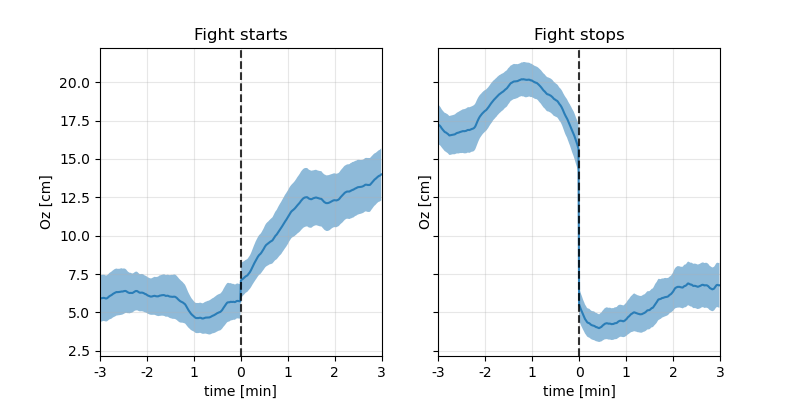

In [100]:
# ---- plot with labels ----- #

fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharey=True)



## --- starts --- #

ax = axs[0]
ax.set_title('Fight starts')

# get where to draw the fight end line
total_num_wins = begin_Oz_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, begin_Oz_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = begin_Oz_means + begin_Oz_bootstrap_std
min_curve = begin_Oz_means - begin_Oz_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_start_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, begin_Oz_means.shape[0])
# ax.set_ylim(0, 0.3)
ax.set_ylabel('Oz [cm]')
ax.set_xlabel('time [min]')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels(xticklabels);
ax.grid(alpha=0.3)



# # -- stops --#

ax = axs[1]
ax.set_title('Fight stops')

# get where to draw the fight end line
total_num_wins = end_Oz_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, end_Oz_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = end_Oz_means + end_Oz_bootstrap_std
min_curve = end_Oz_means - end_Oz_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_start_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, end_Oz_means.shape[0])
# ax.set_ylim(0, 0.3)
ax.set_ylabel('Oz [cm]')
ax.set_xlabel('time [min]')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels(xticklabels);
ax.grid(alpha=0.3)


## plot paper

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
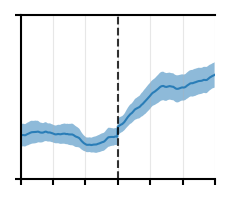

In [104]:
# ---- start---- #

fig, axs = plt.subplots(ncols=1, figsize=(2.3,2), sharey=False)

ax = axs

# get where to draw the fight end line
total_num_wins = begin_Oz_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, begin_Oz_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = begin_Oz_means + begin_Oz_bootstrap_std
min_curve = begin_Oz_means - begin_Oz_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_start_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, begin_Oz_means.shape[0])
# ax.set_ylim(0, 0.3)
ax.set_ylabel('')
ax.set_xlabel('')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels([]);
ax.grid(alpha=0.3)


ax.set_yticks([0, 22])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
for axis in ['right']:
    ax.spines[axis].set_visible(False)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_fig_deltaZ_B.png'
fig.savefig(imsavepath, transparent=True, dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
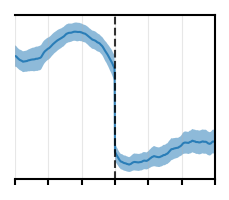

In [111]:
#-----end---- --#

fig, axs = plt.subplots(ncols=1, figsize=(2.3,2), sharey=False)


ax = axs

# get where to draw the fight end line
total_num_wins = end_Oz_means.shape[0]
fight_start_win_idx = int(total_num_wins/2)


xvals = np.arange(0, total_num_wins)

# plot the true mean curve
ax.plot(xvals, end_Oz_means, color='C0', alpha=0.9)

# fill between the stdev lines
max_curve = end_Oz_means + end_Oz_bootstrap_std
min_curve = end_Oz_means - end_Oz_bootstrap_std
ax.fill_between(xvals, y1=min_curve, y2=max_curve, alpha=0.5)


ax.axvline(fight_start_win_idx, color='black', linestyle='--', alpha=0.8)
ax.set_xlim(0, end_Oz_means.shape[0])
# ax.set_ylim(0, 0.3)
ax.set_ylabel('')
ax.set_xlabel('')

xticks = [i*(total_num_wins/6) for i in range(7)]
ax.set_xticks(xticks );
xticklabels = ['-3', '-2', '1', '0', '1', '2', '3']
ax.set_xticklabels([]);
ax.grid(alpha=0.3)

ax.set_yticks([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
for axis in ['left']:
    ax.spines[axis].set_visible(False)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_fig_deltaZ_C.png'
fig.savefig(imsavepath, transparent=True, dpi=300)